# Import libraries

In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Dense, LSTM
from keras.models import Sequential

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Import data

In [2]:
# CO2, Temperature and Humidity values measured every minute in the greenhouse
df = pd.read_csv('data_week.csv', index_col=0)
df.head()

,CO2 (ppm),Temperature (C),Humidity (%)
Date Time,,,
2023-03-16 11:35:30,456,22.67,31.21
2023-03-16 11:36:30,438,21.58,33.16
2023-03-16 11:37:30,445,21.19,33.38
2023-03-16 11:38:30,446,21.09,32.49
2023-03-16 11:39:30,446,21.02,33.16


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11688 entries, 2023-03-16 11:35:30 to 2023-03-24 14:20:12
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CO2 (ppm)        11688 non-null  int64  
 1   Temperature (C)  11688 non-null  float64
 2   Humidity (%)     11688 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 365.2+ KB


In [4]:
df.describe()

,CO2 (ppm),Temperature (C),Humidity (%)
count,11688.000000,11688.000000,11688.000000
mean,588.642796,22.127713,45.067269
std,241.142252,1.482375,7.819816
min,383.000000,18.630000,25.750000
25%,423.000000,21.170000,40.607500
50%,471.000000,22.290000,45.135000
75%,671.000000,23.210000,49.670000
max,1587.000000,25.210000,70.520000


# Visualization

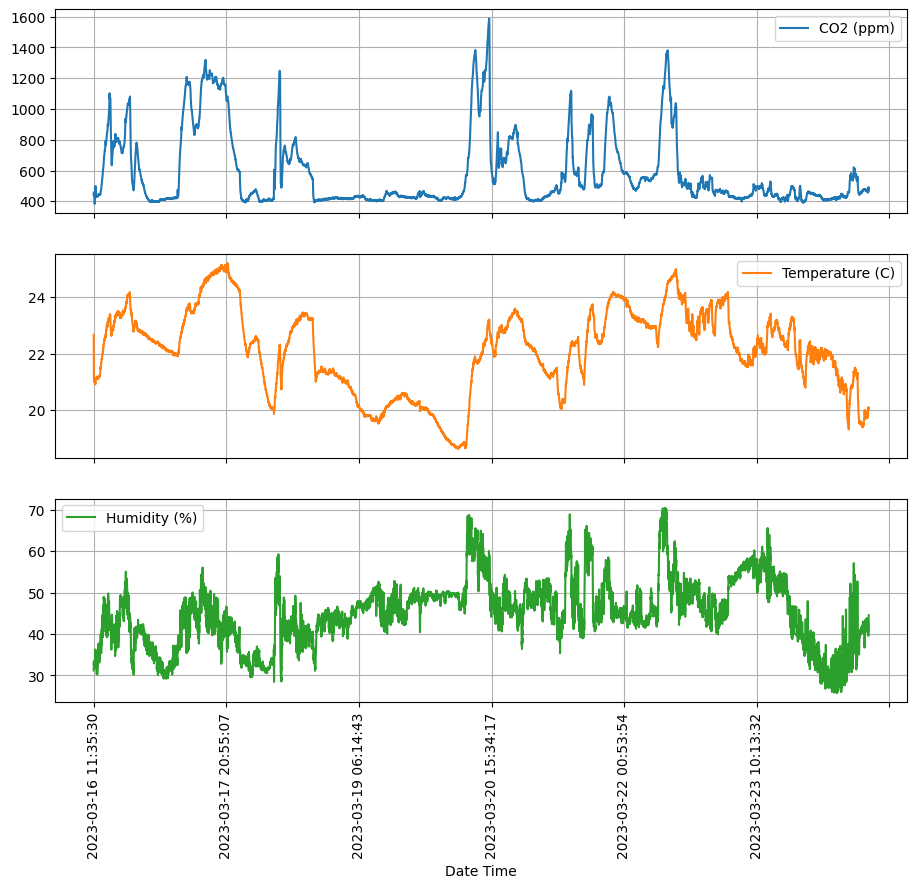

In [5]:
df.plot(figsize=(11, 9), subplots=True, grid=True)
plt.xticks(rotation=90);

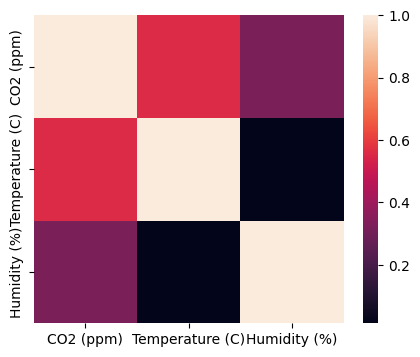

In [6]:
# columns correlation
plt.figure(figsize=(5,4))
sns.heatmap(df.corr().abs());

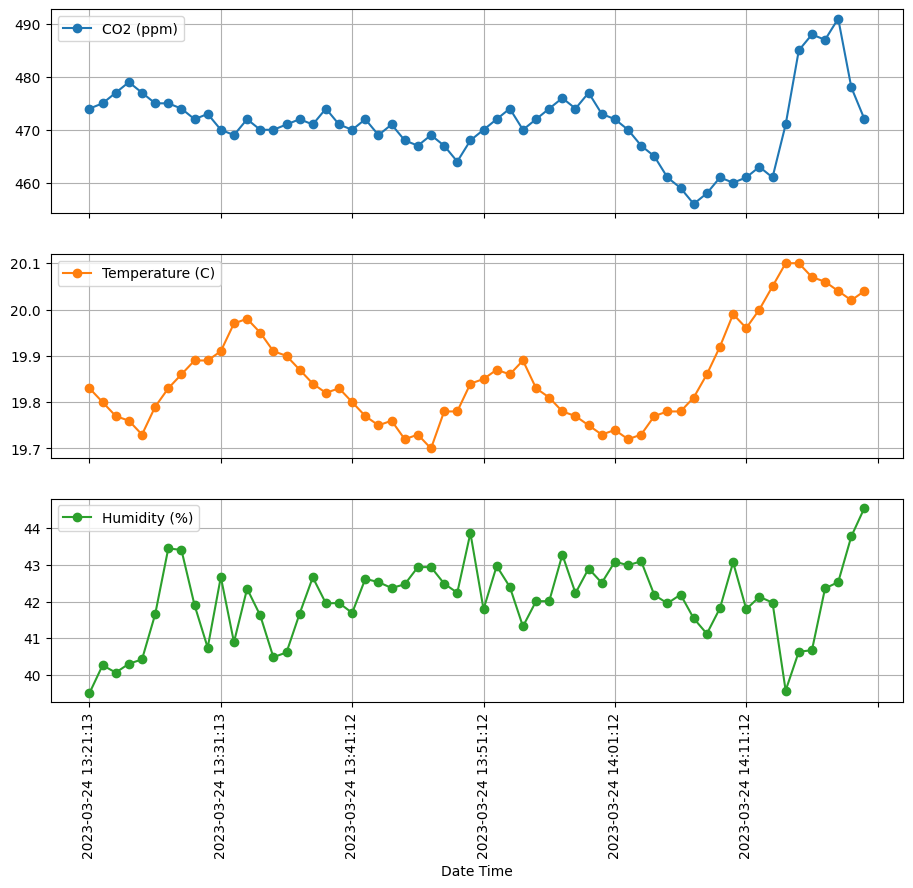

In [7]:
# change in last one hour
df[-60:].plot(figsize=(11, 9), subplots=True, marker='o', linestyle='-', grid=True)
plt.xticks(rotation=90);

# Data preprocessing

In [8]:
# rename columns
df = df.rename(columns={'CO2 (ppm)':'CO2','Temperature (C)':'Temperature','Humidity (%)':'Humidity'})

In [9]:
# drop the variables into the same range for the model works well
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df.values), index=df.index, columns=df.columns)

In [10]:
# drop the last value and save X variable
X = df.drop(df.index[-1])

# get all value except first value and save Y variable
Y = pd.DataFrame(df.values[1:], index=df.index[:-1], columns=['Y_CO2','Y_Temperature','Y_Humidity'])

In [11]:
# prepared data view
pd.concat([X,Y], axis=1)

,CO2,Temperature,Humidity,Y_CO2,Y_Temperature,Y_Humidity
Date Time,,,,,,
2023-03-16 11:35:30,0.060631,0.613982,0.121957,0.045681,0.448328,0.165513
2023-03-16 11:36:30,0.045681,0.448328,0.165513,0.051495,0.389058,0.170427
2023-03-16 11:37:30,0.051495,0.389058,0.170427,0.052326,0.373860,0.150547
2023-03-16 11:38:30,0.052326,0.373860,0.150547,0.052326,0.363222,0.165513
2023-03-16 11:39:30,0.052326,0.363222,0.165513,0.051495,0.367781,0.140719
...,...,...,...,...,...,...
2023-03-24 14:15:12,0.084718,0.223404,0.332365,0.087209,0.218845,0.333259
2023-03-24 14:16:12,0.087209,0.218845,0.333259,0.086379,0.217325,0.371007
2023-03-24 14:17:12,0.086379,0.217325,0.371007,0.089701,0.214286,0.374805


In [12]:
# split to train and test
X_train, X_test, y_train, y_test = train_test_split(X.values, Y.values, test_size=0.3, shuffle=False)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8180, 3) (8180, 3) (3507, 3) (3507, 3)


In [13]:
# reshape
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8180, 1, 3) (8180, 3) (3507, 1, 3) (3507, 3)


# Model building

In [14]:
# 1D Convolutional Neural Network Model
model = Sequential([
    LSTM(64, input_shape=(1,3)),
    Dense(3)
])

In [15]:
# compile
model.compile(optimizer='adam', loss='mae')

In [16]:
# model fitting
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
256/256 [==============================] - 6s 9ms/step - loss: 0.1193 - val_loss: 0.0492
Epoch 2/50
256/256 [==============================] - 2s 8ms/step - loss: 0.0158 - val_loss: 0.0141
Epoch 3/50
256/256 [==============================] - 3s 12ms/step - loss: 0.0102 - val_loss: 0.0123
Epoch 4/50
256/256 [==============================] - 2s 8ms/step - loss: 0.0096 - val_loss: 0.0119
Epoch 5/50
256/256 [==============================] - 1s 4ms/step - loss: 0.0095 - val_loss: 0.0117
Epoch 6/50
256/256 [==============================] - 1s 4ms/step - loss: 0.0093 - val_loss: 0.0113
Epoch 7/50
256/256 [==============================] - 1s 4ms/step - loss: 0.0091 - val_loss: 0.0117
Epoch 8/50
256/256 [==============================] - 1s 4ms/step - loss: 0.0091 - val_loss: 0.0120
Epoch 9/50
256/256 [==============================] - 1s 4ms/step - loss: 0.0090 - val_loss: 0.0118
Epoch 10/50
256/256 [==============================] - 2s 6ms/step - loss: 0.0090 - val_loss: 0.010

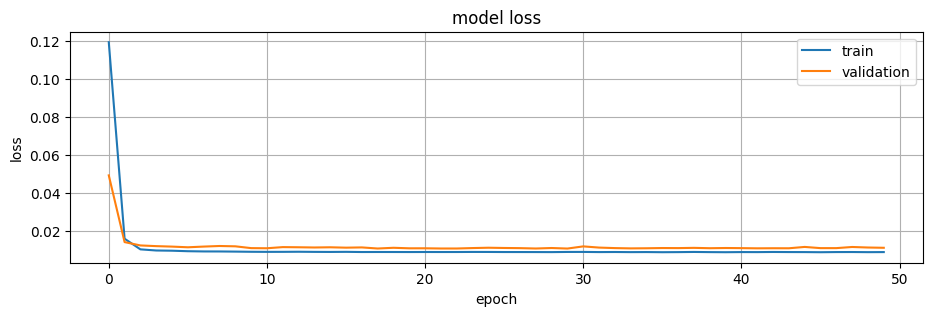

In [17]:
plt.figure(figsize=(11,3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [26]:
# save model
model.save("models/lstm.h5")

In [19]:
# prediction
pred = model.predict(X_test)

110/110 [==============================] - 1s 3ms/step


In [20]:
# MinMaxScaler inverse transform
pred = scaler.inverse_transform(pred)
y_test = scaler.inverse_transform(y_test)

# Evaluation

In [21]:
print('Mean absolute error:',mean_absolute_error(y_test, pred))
print('Mean squared error:',mean_squared_error(y_test, pred))
print('Root mean squared error:',mean_squared_error(y_test, pred)**(1/2))

Mean absolute error: 1.7397742465638972
Mean squared error: 10.672152143070697
Root mean squared error: 3.2668260044071364


In [22]:
print('Coefficient of determination (r2 score):',r2_score(y_test, pred))

Coefficient of determination (r2 score): 0.9877220046254326


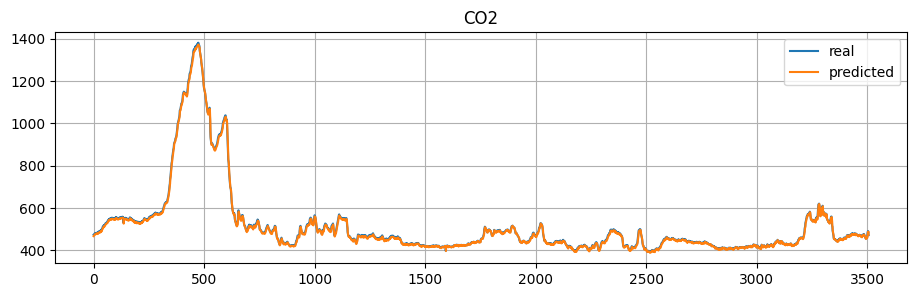

In [23]:
plt.figure(figsize=(11,3))
plt.plot(y_test[:,0])
plt.plot(pred[:,0])
plt.title('CO2')
plt.grid()
plt.legend(['real', 'predicted'], loc='upper right')
plt.show()

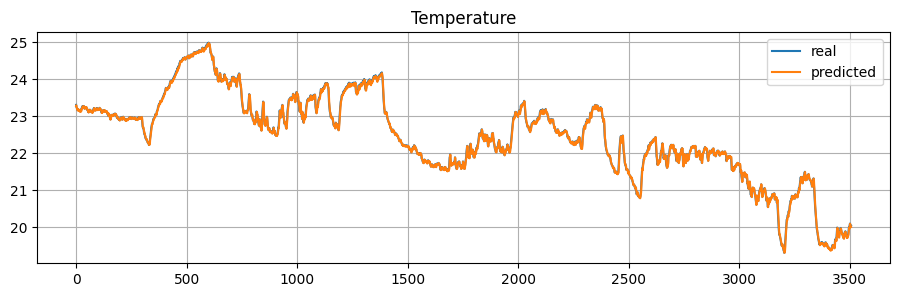

In [24]:
plt.figure(figsize=(11,3))
plt.plot(y_test[:,1])
plt.plot(pred[:,1])
plt.title('Temperature')
plt.grid()
plt.legend(['real', 'predicted'], loc='upper right')
plt.show()

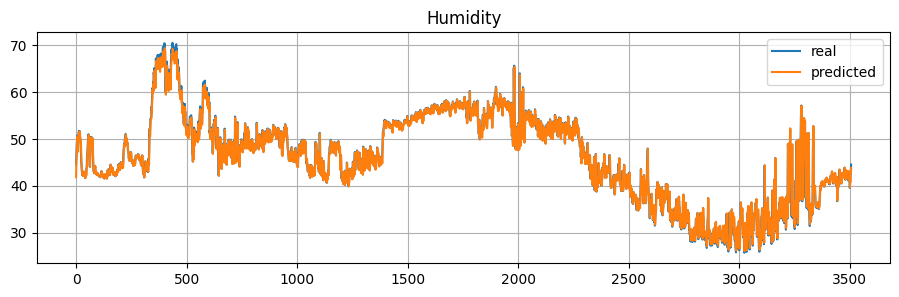

In [25]:
plt.figure(figsize=(11,3))
plt.plot(y_test[:,2])
plt.plot(pred[:,2])
plt.title('Humidity')
plt.grid()
plt.legend(['real', 'predicted'], loc='upper right')
plt.show()